# Sentiment classifier with LSTM

In this notebook, we will implement a simple sentiment classifier using an LSTM. Follow the notebook, complete the missing part, answer the questions and apply the asked modifications.



In [1]:
!pip install datasets

In [2]:
from collections import defaultdict
from copy import deepcopy
import re
from typing import Callable, List, Tuple

from datasets import load_dataset
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch import nn
import torch.nn.functional as F
from tqdm.auto import tqdm
from datetime import datetime
from sklearn.utils import shuffle

## Downloading the dataset

Using the datasets library, we load the imdb dataset.

In [3]:
dataset = load_dataset("imdb")

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb downloaded and prepared to /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

In [5]:
# We do not need the "unsupervised" split.
dataset.pop("unsupervised")

Dataset({
    features: ['text', 'label'],
    num_rows: 50000
})

In [6]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
})

In [7]:
dataset["train"][:2]

{'text': ['I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far b

## Pretreatment **(1 point)**

Code the `pretreatment` function which clean the input text. Look at the dataset and deduce which treatment is needed.

In [8]:
import re
from string import punctuation

def clean_html(sentence: str) -> str:
    pattern = re.compile('<.*?>')
    cleaned_text = re.sub(pattern,' ', sentence)
    return cleaned_text

def remove_url(sentence: str) -> str:
    cleaned_http_text = re.sub(r"http\S+", " ", sentence)
    cleaned_www_text = re.sub(r"www.\S+", " ", cleaned_http_text)
    return cleaned_www_text

def remove_extra(sentence: str) -> str: 
    cleaned_text  = re.sub("\\s*\\b(?=\\w*(\\w)\\1{2,})\\w*\\b",' ', sentence)
    return cleaned_text

def lowercase_and_remove_punc(sentence: str) -> str:
    return sentence.lower().translate(str.maketrans("", "", punctuation))

In [9]:
def pretreatment(text: str) -> str:
    """
    Clean IMDB text entries.
    Args:
        text: an input string.
    Returns:
        The cleaned text.
    """
    text = clean_html(text)
    text = lowercase_and_remove_punc(text)
    text = remove_url(text)
    text = remove_extra(text)
    # Your code here
    return text

In [10]:
# This applies the pretreatment function to all
clean_dataset = dataset.map(lambda x: {"text": pretreatment(x["text"]), "label": x["label"]})

  0%|          | 0/25000 [00:00<?, ?ex/s]

  0%|          | 0/25000 [00:00<?, ?ex/s]

Let's see what the text now look like.

In [11]:
clean_dataset["train"]["text"][:3]

['i rented i am curiousyellow from my video store because of all the controversy that surrounded it when it was first released in 1967 i also heard that at first it was seized by us customs if it ever tried to enter this country therefore being a fan of films considered controversial i really had to see this for myself  the plot is centered around a young swedish drama student named lena who wants to learn everything she can about life in particular she wants to focus her attentions to making some sort of documentary on what the average swede thought about certain political issues such as the vietnam war and race issues in the united states in between asking politicians and ordinary denizens of stockholm about their opinions on politics she has sex with her drama teacher classmates and married men  what kills me about i am curiousyellow is that 40 years ago this was considered pornographic really the sex and nudity scenes are few and far between even then its not shot like some cheaply

Let's take a quick look at the labels. Notice that the labels are ordered in the training set starting by the negative reviews (0), followed by the positive ones (1). Training neural networks on this kind of configuration tends to considerably affect their performances. So the dataset will have to be shuffled.

In [12]:
clean_dataset["train"]["label"][12490:12510]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

So here we are shuffling our dataset.

In [13]:
clean_dataset = clean_dataset.shuffle(seed=42)
clean_dataset["train"]["label"][12490:12510]

[1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1]

## Train/validation split **(1 point)**

In our example, we consider the test split as production data. Which means, we need to treat it as if we never see it during the training process. To experiment on the model, we need to split the training set into a training and validation set. See [here](https://huggingface.co/course/chapter5/3?fw=pt#creating-a-validation-set) on how to do so with the `Datasets` library.

Don't forget to **stratify** your split (we need to have the same proportion of class in both training and validation set).

In [16]:
train = clean_dataset["train"].train_test_split(train_size=0.85, seed=42)
clean_dataset["validation"] = train["test"]
clean_dataset["train"] = train["train"]

In [17]:
clean_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 21250
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 3750
    })
})

In [18]:
# Check here that the dataset is stratified.
train_stratified = len(train["train"].filter(lambda x : x["label"] == 1)) / len(train["train"])
validation_stratified = len(train["test"].filter(lambda x : x["label"] == 1)) / len(train["test"])

print("Rate labelled 1 for 'test' split:", train_stratified)
print("Rate labelled 1 for 'validation' split:", validation_stratified)

  0%|          | 0/22 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

Rate labelled 1 for 'test' split: 0.5014117647058823
Rate labelled 1 for 'validation' split: 0.492


## Categorical encoding of the vocabulary **(2 points)**

We can't feed word to a neural network. A usual solution is to turn words into categorical data by using one-hot encoding. To avoid an explosion in vocabulary size, we will only keep words which appear more than a certain amount of time.

The `Vocabulary` class below will do that for us.

In [19]:
UNK_TOKEN = "<UNK>"
PAD_TOKEN = "<PAD>"


class Vocabulary:
    """Vocabulary manager on a collection.
    """
    def __init__(self) -> None:
        """No parameters to provide.
        """
        # Index to word mapping.
        self.index2word = [PAD_TOKEN, UNK_TOKEN]
        # Word to index mapping.
        self.word2index = {value: key for key, value in enumerate(self.index2word)}
        # Word counter.
        self.word2count = defaultdict(int)

    def add_word(self, word: str) -> None:
        """Increments the count of a word to the vocabulary.
        Args:
            word: the word.
        """
        self.word2count[word] += 1
        if not word in self.word2index:
            self.word2index[word] = len(self.index2word)
            self.index2word.append(word)

    def add_text(self, text: str, separator: str =" ") -> None:
        """Add the words given in a text to our vocabulary.
        Args:
            text: a sequence of words separated by a given separator.
            separator: the separator used to split our text (default is " ").
        """
        for word in text.split(separator):
            self.add_word(word)

    def get_index(self, word: str) -> int:
        """Returns the index of a given word in our vocabulary.
        If the word is not in the vocabulary, returns the index for UNK_TOKEN.
        Args:
            word: a string.
        Returns:
            The corresponding index or the index for UNK_TOKEN.
        """
        return (
            self.word2index[word]
            if word in self.word2index
            else self.word2index[UNK_TOKEN]
        )

    def get_word(self, index: int) -> str:
        """Returns the word at a given index in our vocabulary.
        Args:
            index: the word position in our vocabulary.
        Returns:
            The word corresponding to the given index.
        """
        return self.index2word[index]

    def get_word_count(self, word: str) -> int:
        """Returns the number of occurences for a given word.
        Raise a 
        Args:
            The word.
        Returns:
            Its number of measured occurences.
        """
        return self.word2count[word]

    def get_vocabulary(self) -> List[str]:
        """Returns a copy of the whole vocabulary list.
        Returns:
            A list of words.
        """
        return deepcopy(self.index2word)

    def __len__(self) -> int:
        """len() function.
        Returns:
            The number of words in the vocabulary.
        """
        return len(self.index2word)

    def trim_vocabulary(self, min_occurences: int = 5) -> None:
        """Trim the vocabulary based on the number of occurrences of each words.
        Note that whole counts of deleted words are added to the UNK_TOKEN counts.
        Args:
            min_occurences: the minimum number of occurences for a word to be kept.
        """
        to_delete = {
            word for word, count in self.word2count.items() if count < min_occurences
        }
        new_word2count = defaultdict(int)
        for word, count in self.word2count.items():
            if word not in to_delete:
                new_word2count[word] = count
            else:
                new_word2count[UNK_TOKEN] += count
        new_index2word = [word for word in self.index2word if word not in to_delete]
        new_word2index = {word: index for index, word in enumerate(new_index2word)}

        self.word2count = new_word2count
        self.index2word = new_index2word
        self.word2index = new_word2index

**(1 point)** Get the vocabulary on both the training and validation set using the `Vocabulary` class. Remember, we don't use the test set here as we consider it as proxy production data. The trim it down as you see fit (around 20K words in the vocabulary is a good value).

In [20]:
vocabulary = Vocabulary()

# Your code...
vocabulary = Vocabulary()

for text in clean_dataset["train"]["text"]:
  vocabulary.add_text(text)

for text in clean_dataset["validation"]["text"]:
  vocabulary.add_text(text)


vocabulary.trim_vocabulary(min_occurences=11)
len(vocabulary)

19479

**(1 point)** Fill the encoding and decoding functions. The encoding function takes a text as input and returns a list IDs corresponding to the index of each word in the vocabulary. The decoding function reverse the process, turning a list of IDs into a text. Make sure the encoding function returns a numpy array.

In [21]:
# Encoding and decoding function

def encode_text(text: str) -> np.ndarray:
    # Your code.
    id_list = []
    for word in text.split(" "):
      id_list.append(vocabulary.get_index(word))
    return np.array(id_list)


def decode_text(encoded_text: np.ndarray) -> str:
    # Your code.
    result = ""
    for id in encoded_text:
      result += " " + vocabulary.get_word(id)
    return result

To make sure everything went well, we compare a text before and after encoding and then decoding it. You should see rare words / typos replaced by the `<UNK>` token.

In [22]:
# Apply the encoding function to the entire dataset.
encoded_dataset = clean_dataset.map(lambda x: {"text": encode_text(x["text"]), "label": x["label"]})

  0%|          | 0/21250 [00:00<?, ?ex/s]

  0%|          | 0/25000 [00:00<?, ?ex/s]

  0%|          | 0/3750 [00:00<?, ?ex/s]

In [23]:
clean_dataset["train"]["text"][0], decode_text(encoded_dataset["train"]["text"][0])

('i remember devil dog playing on tbs almost 20 years ago and my older sister and her friends watching it and laughing all the next day its not that bad for a madefortv horror movie but it is derivative mostly of the exorcist and businesslike for lack of a better word it wont blow you away with artful cinematography or great acting but its not a waste of time either its the kind of movie you watch to kill a couple of hours when you arent in the mood to think too hard  however if you go into the movie looking for some laughs you wont be disappointed the early scenes with lucky the devil dog as a cute little puppy with children of the damned eyes are hilariously nonthreatening and the climactic bluescreen effects of a giant black dog with horns are pretty sidesplitting and keep an eye out for the cloaked satanist in maverick shades toward the beginning  not a great horror film by any stretch of the imagination but i wish they still made stuff like this for tv',
 ' i remember devil dog pl

## Batch preparation **(1 point)**

To speed up learning, and take advantage of the GPU architecture, we provide data to the model by batches. Since all line in the same batch need to have the same length, we pad lines to the maximum length of each batch.

In [24]:
def data_generator(X: np.ndarray, y: np.ndarray, batch_size: int = 32, pad_right: bool = False) -> Tuple[np.ndarray, np.ndarray]:
    """Generate randomly ordered batches of data+labels.
    Args:
        X: the input data.
        y: the corresponding labels.
        batch_size: the size of each batch [32].
        pad_right: if true, the padding is done on the right [False].
    """
    
    X, y = shuffle(X, y)
    n_batches = int(np.ceil(len(y) / batch_size))
    
    for i in range(n_batches):
        
        end = min((i+1)*batch_size, len(y))
        
        X_batch = X[i*batch_size:end]
        y_batch = y[i*batch_size:end]

        # Padding to max ength size within the batch
        max_len = np.max([len(x) for x in X_batch])
        for j in range(len(X_batch)):
            x = X_batch[j]
            pad = [vocabulary.get_index(PAD_TOKEN)] * (max_len - len(x))
            X_batch[j] = x+pad if pad_right else pad+x

        X_batch = torch.from_numpy(np.array(X_batch)).long()
        y_batch = torch.from_numpy(np.array(y_batch)).long()

        # Yielding results, so every time the function is called, it starts again from here.
        yield X_batch, y_batch

Let's see what the batches look like.

In [25]:
for inputs, targets in data_generator(encoded_dataset["train"]["text"], encoded_dataset["train"]["label"]):
    print("inputs", inputs, "shape:", inputs.shape)
    print("targets", targets, "shape:", targets.shape)
    break

inputs tensor([[    0,     0,     0,  ...,  2249,     1,  8183],
        [    0,     0,     0,  ...,    22, 10052,  1658],
        [    0,     0,     0,  ...,    47,   208,   574],
        ...,
        [    0,     0,     0,  ...,    57,   192,   461],
        [    0,     0,     0,  ..., 15539,    22,   288],
        [    0,     0,     0,  ...,    38,    22,  2523]]) shape: torch.Size([32, 673])
targets tensor([1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0,
        0, 1, 1, 0, 0, 0, 1, 1]) shape: torch.Size([32])


**(1 point)** Question: On which side should we pad the data for our use case and why?

The previous cells show us that we have lots of '0' values on the left of our tensors. So we should pad our data on the right here to improve our predictions and our model generally.

## The model **(13 points)**

We use a simple RNN with a configurable number of layers.

In [26]:
# Before starting, let's set up the device. A GPU if available, else the CPU.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [27]:
class RNN(nn.Module):
    """A simple RNN module with word embeddings.
    """
    def __init__(self, vocab_size: int, embed_size: int, hidden_size: int, n_layers: int, n_outputs: int) -> None:
        """
        Args:
            vocab_size: vocabulary size.
            embed_size: embedding dimensions.
            hidden_size: hidden layer size.
            n_layers: the number of layers.
            n_outputs: the number of output classes.
        """
        super().__init__()
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.n_outputs = n_outputs


        # The word embedding layer.
        self.embed = nn.Embedding(self.vocab_size, self.embed_size)
        # The RNN
        self.rnn = nn.RNN(
            input_size = self.embed_size,
            hidden_size = self.hidden_size,
            num_layers = self.n_layers,
            batch_first = True, # Changes the order of dimension to put the batches first.
        )
        # A fully connected layer to project the RNN's output to only one output used for classification.
        self.fc = nn.Linear(self.hidden_size, self.n_outputs)

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """Function called when the model is called with data as input.
        Args:
            X: the input tensor of dimensions batch_size, sequence length, vocab size (actually just an int).
        Returns:
            The resulting tensor of dimension batch_size, sequence length, output dimensions.
        """
        h0 = torch.zeros(self.n_layers, X.size(0), self.hidden_size).to(device)

        out = self.embed(X)
        # out contains the output layer of all words in the sequence.
        # First dim is batch, second the word in the sequence, third is the vector itself.
        # The second output value is the last vector of all intermediate layer.
        # Only use it if you want to access the intermediate layer values of a
        # multilayer model.
        out, _ = self.rnn(out, h0)
        # Getting the last value only.
        out = out[:, -1, :]
    
        # Linear projection.
        out = self.fc(out)

        return out

Note that we do not pass the output through a sigmoid function. This is because pyTorch implements some code optimization within the `BCEWithLogitsLoss` we'll see later.

In [28]:
def train(
    model: nn.Module,
    criterion: Callable,
    optimizier: torch.optim.Optimizer,
    n_epochs: int,
    train_gen: Callable,
    valid_gen: Callable,
) -> Tuple[List[float], List[float]]:
    """Train a model using a batch gradient descent.
    Args:
        model: a class inheriting from nn.Module.
        criterion: a loss criterion.
        optimizer: an optimizer (e.g. Adam, RMSprop, ...).
        n_epochs: the number of training epochs.
        train_gen: a callable function returing a batch (data, labels).
        valid_gen: a callable function returing a batch (data, labels).
    """
    train_losses = np.zeros(n_epochs)
    valid_losses = np.zeros(n_epochs)

    for epoch in range(n_epochs):

        t0 = datetime.now()
        model.train()
        train_loss = []

        # Training loop.
        for inputs, labels in train_gen():
            # labels are of dimension (N,) we turn them into (N, 1).
            labels = labels.view(-1, 1).float()
            # Put them on the GPU.
            inputs, labels = inputs.to(device), labels.to(device)

            # Reset the gradient.
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizier.step()

            train_loss.append(loss.item())  # .item() detach the value from GPU.

        train_losses[epoch] = np.mean(train_loss)

        model.eval()
        valid_loss = []
        # Evaluation loop.
        for inputs, labels in valid_gen():
            labels = labels.view(-1, 1).float()
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            valid_loss.append(loss.item())

        valid_losses[epoch] = np.mean(valid_loss)

        print(f"Epoch: {epoch}, training loss: {train_losses[epoch]}, validation loss: {valid_losses[epoch]}, in {datetime.now() - t0}")

    return train_losses, valid_losses, model

We setup the model, criterion (a binary cross entropy), and the optimizer (Adam).

Note that `BCEWithLogitsLoss` use a mathematical trick to incorporate the sigmoid function in its computation. This trick makes the learning process go slightly faster and is the reason why we didn't put a sigmoid in the forward function of the model.

In [29]:
model = RNN(len(vocabulary), 32, 64, 1, 1).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters())

We get the 3 generators.

In [30]:
train_gen = lambda: data_generator(encoded_dataset["train"]["text"], encoded_dataset["train"]["label"])
valid_gen = lambda: data_generator(encoded_dataset["validation"]["text"], encoded_dataset["validation"]["label"])
test_gen = lambda: data_generator(encoded_dataset["test"]["text"], encoded_dataset["test"]["label"])

And train the model.

In [32]:
train_losses, valid_losses, model = train(model, criterion, optimizer, 10, train_gen, valid_gen)

Epoch: 0, training loss: 0.5576852846862679, validation loss: 0.5539961437047538, in 0:00:19.693480
Epoch: 1, training loss: 0.5633144084672282, validation loss: 0.618925933615636, in 0:00:19.700582
Epoch: 2, training loss: 0.504536175279689, validation loss: 0.5498603963750904, in 0:00:19.817405
Epoch: 3, training loss: 0.45657504714073094, validation loss: 0.5650708142478588, in 0:00:19.761631
Epoch: 4, training loss: 0.551116139772243, validation loss: 0.6304603019508265, in 0:00:19.977772
Epoch: 5, training loss: 0.49895164007531073, validation loss: 0.5745943890789807, in 0:00:19.806633
Epoch: 6, training loss: 0.44181325388582127, validation loss: 0.5526986094349522, in 0:00:19.630909
Epoch: 7, training loss: 0.40328724895204815, validation loss: 0.5814018353062161, in 0:00:20.085427
Epoch: 8, training loss: 0.40414331488143235, validation loss: 0.5504694333520986, in 0:00:19.432791
Epoch: 9, training loss: 0.39811655490246034, validation loss: 0.7495326210381621, in 0:00:20.3847

We can look at the training and validation loss.

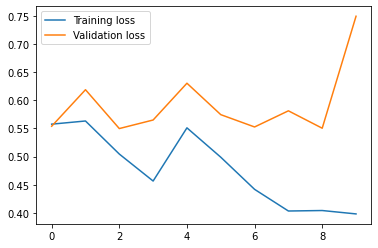

In [33]:
plt.plot(train_losses, label="Training loss")
plt.plot(valid_losses, label="Validation loss")
plt.legend()

* **(2 points)** The model validation loss should go down and then up. It means the model starts overfitting after a certain number of iterations. Modify the `train` function so it returns the model found with the best validation loss.

Here the solution is to keep a reference of our best model with the lowest loss. We just have to return our best model to avoid the overfitting of the model after a certain number of iterations.

In [34]:
def train(
    model: nn.Module,
    criterion: Callable,
    optimizier: torch.optim.Optimizer,
    n_epochs: int,
    train_gen: Callable,
    valid_gen: Callable,
) -> Tuple[List[float], List[float]]:
    """Train a model using a batch gradient descent.
    Args:
        model: a class inheriting from nn.Module.
        criterion: a loss criterion.
        optimizer: an optimizer (e.g. Adam, RMSprop, ...).
        n_epochs: the number of training epochs.
        train_gen: a callable function returing a batch (data, labels).
        valid_gen: a callable function returing a batch (data, labels).
    """
    train_losses = np.zeros(n_epochs)
    valid_losses = np.zeros(n_epochs)
    
    #######
    # Variables used to save the best model with the lowest loss
    min_valid_loss = 1.0
    best_model = model
    ######

    for epoch in range(n_epochs):

        t0 = datetime.now()
        model.train()
        train_loss = []

        # Training loop.
        for inputs, labels in train_gen():
            # labels are of dimension (N,) we turn them into (N, 1).
            labels = labels.view(-1, 1).float()
            # Put them on the GPU.
            inputs, labels = inputs.to(device), labels.to(device)

            # Reset the gradient.
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizier.step()

            train_loss.append(loss.item())  # .item() detach the value from GPU.

        train_losses[epoch] = np.mean(train_loss)

        model.eval()
        valid_loss = []
        # Evaluation loop.
        for inputs, labels in valid_gen():
            labels = labels.view(-1, 1).float()
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            valid_loss.append(loss.item())

        valid_losses[epoch] = np.mean(valid_loss)

        
        if valid_losses[epoch] < min_valid_loss:
            min_valid_loss = valid_losses[epoch]
            best_model = model

        print(f"Epoch: {epoch}, training loss: {train_losses[epoch]}, validation loss: {valid_losses[epoch]}, in {datetime.now() - t0}")

    return train_losses, valid_losses, best_model

Epoch: 0, training loss: 0.290281559274833, validation loss: 0.6221387669191523, in 0:00:19.914774
Epoch: 1, training loss: 0.262991003888218, validation loss: 0.5656967283052913, in 0:00:19.880610
Epoch: 2, training loss: 0.28361152864264366, validation loss: 0.5662777048803992, in 0:00:19.755313
Epoch: 3, training loss: 0.27209988091897247, validation loss: 0.5946385967781989, in 0:00:20.318313
Epoch: 4, training loss: 0.31440607497566625, validation loss: 0.8130727973529848, in 0:00:19.611230
Epoch: 5, training loss: 0.35734394498561556, validation loss: 0.6472510811636003, in 0:00:19.848238
Epoch: 6, training loss: 0.2894641899412736, validation loss: 0.6310875489044998, in 0:00:19.800481
Epoch: 7, training loss: 0.30798826820980335, validation loss: 0.6704346773735548, in 0:00:19.793125
Epoch: 8, training loss: 0.3952791606181098, validation loss: 0.6004404112444086, in 0:00:19.715245
Epoch: 9, training loss: 0.42908318332935635, validation loss: 0.6674467638387518, in 0:00:19.894

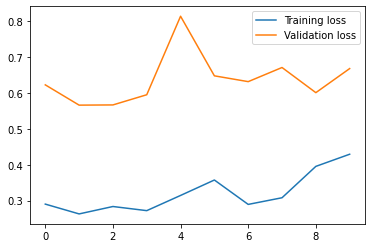

In [36]:
train_losses, valid_losses, best_model = train(model, criterion, optimizer, 10, train_gen, valid_gen)

plt.plot(train_losses, label="Training loss")
plt.plot(valid_losses, label="Validation loss")
plt.legend()

* **(2 points)** Add an accuracy function and report the accuracy of the training and test set.


In [37]:
def accuracy(targets: List[str], preds: List[str]) -> float:
    """
    Compute the accuracy between target and predicted labels
    
    Args:
        targets: List[str] the expected labels
        preds : List[str] the predicted labels
    Return:
        float => Accuracy between target and predicted labels.
    """
    diff = [1 if pred == target else 0 for (pred, target) in zip(preds, targets)]
    return round(sum(diff) / len(diff), 2)

def predict(model: nn.Module, generator: Callable) -> (List[str], List[str]):
    """
    Get the predicted label of all the inputs in generator. 
    
    Args:
        model: nn.Module Our RNN prediction model
        generator : Callable Contains our inputs and labels for a specific part of our dataset
    Return:
        (List[str], List[str]) => The list of the predicted labels and the list of the targeted labels.
    """
    targets = []
    preds = []
    for inputs, labels in generator():
        inputs = inputs.to(device)
        outputs = model(inputs)
        predicted_labels = [0 if i < 0 else 1 for i in [e for l in outputs.tolist() for e in l]]
        targets.append(labels.tolist())
        preds.append(predicted_labels)
    preds = [p for l in preds for p in l]
    targets = [t for l in targets for t in l]
    return targets, preds 

targets_train, preds_train = predict(best_model, train_gen)
targets_test, preds_test = predict(best_model, test_gen)
targets_valid, preds_valid = predict(best_model, valid_gen)

print("Train dataset accuracy", accuracy(targets_train, preds_train))
print("Test dataset accuracy", accuracy(targets_test, preds_test))
print("Validation dataset accuracy", accuracy(targets_valid, preds_valid))

Train dataset accuracy 0.66
Test dataset accuracy 0.59
Validation dataset accuracy 0.6


We can see that the accuracy is quite good for a simple RNN model with 0.69 of accuracy on the test dataset.

* **(3 points)** Create an LSTM class which uses an LSTM instead of an RNN. Compare its results with the RNN.


In [38]:
class LSTM(nn.Module):

    def __init__(self, vocab_size: int, embed_size: int, hidden_size: int, n_layers: int, n_outputs: int) -> None:
        """
        Args:
            vocab_size: vocabulary size.
            embed_size: embedding dimensions.
            hidden_size: hidden layer size.
            n_layers: the number of layers.
            n_outputs: the number of output classes.
        """
        super().__init__()
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.n_outputs = n_outputs

        # The word embedding layer.
        self.embed = nn.Embedding(self.vocab_size, self.embed_size)
        # LSTM layer process the vector sequences 
        self.lstm = nn.LSTM(
            input_size = self.embed_size,
            hidden_size = self.hidden_size,
            num_layers = self.n_layers,
            batch_first = True, # Changes the order of dimension to put the batches first.
        )
        # A fully connected layer to project the RNN's output to only one output used for classification.
        self.fc = nn.Linear(hidden_size, self.n_outputs)

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """Function called when the model is called with data as input.
        Args:
            X: the input tensor of dimensions batch_size, sequence length, vocab size (actually just an int).
        Returns:
            The resulting tensor of dimension batch_size, sequence length, output dimensions.
        """
        # Initialize the needed values for the LSTM
        h0 = torch.zeros(self.n_layers, X.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.n_layers, X.size(0), self.hidden_size).to(device)

        out = self.embed(X)
        # out contains the output layer of all words in the sequence.
        # First dim is batch, second the word in the sequence, third is the vector itself.
        # The second output value is the last vector of all intermediate layer.
        # Only use it if you want to access the intermediate layer values of a
        # multilayer model.

        # Using our LSTM layer
        out, _ = self.lstm(out, (h0, c0))

        # Getting the last value only.
        out = out[:, -1, :]
        # Linear projection.
        out = self.fc(out)

        return out

In [39]:
lstm_model = LSTM(len(vocabulary), 32, 64, 1, 1).to(device)

train_losses, valid_losses, best_lstm_model = train(lstm_model, criterion, optimizer, 10, train_gen, valid_gen)

Epoch: 0, training loss: 0.6947778371043671, validation loss: 0.6930723321639886, in 0:00:23.695922
Epoch: 1, training loss: 0.6948347795278507, validation loss: 0.6934176759194519, in 0:00:23.487746
Epoch: 2, training loss: 0.694817394511144, validation loss: 0.6933414299609297, in 0:00:23.708706
Epoch: 3, training loss: 0.6949200185618006, validation loss: 0.6931533722554223, in 0:00:24.055199
Epoch: 4, training loss: 0.694785868045979, validation loss: 0.6932934744883392, in 0:00:23.581040
Epoch: 5, training loss: 0.69477525850884, validation loss: 0.6932709222122774, in 0:00:23.417138
Epoch: 6, training loss: 0.6947947516477198, validation loss: 0.6933369399127314, in 0:00:23.693498
Epoch: 7, training loss: 0.6947586857286611, validation loss: 0.6934463002924192, in 0:00:23.546090
Epoch: 8, training loss: 0.6949002864665554, validation loss: 0.6932142957792444, in 0:00:23.411544
Epoch: 9, training loss: 0.6947917002484314, validation loss: 0.6933101541915182, in 0:00:23.432922


In [40]:
lstm_targets_train, lstm_preds_train = predict(best_lstm_model, train_gen)
lstm_targets_test, lstm_preds_test = predict(best_lstm_model, test_gen)
lstm_targets_valid, lstm_preds_valid = predict(best_lstm_model, valid_gen)

print("Train dataset accuracy", accuracy(lstm_targets_train, lstm_preds_train))
print("Test dataset accuracy", accuracy(lstm_targets_test, lstm_preds_test))
print("Validation dataset accuracy", accuracy(lstm_targets_valid, lstm_preds_valid))

Train dataset accuracy 0.5
Test dataset accuracy 0.5
Validation dataset accuracy 0.51


---

* **(2 point)** Implement a function which takes any text and return the model's prediction.
    * The function should have a string as input and return a class (0 or 1) and its probability (score out of a [sigmoid](https://pytorch.org/docs/stable/generated/torch.sigmoid.html)).
    * Don't forget to make the text go through the same pretreatment and encoding you used to train your model.

In [44]:
def predict_string_input(model: nn.Module, str_input: str) -> (str, float):
    """
    Use model to predict label and probability for a single string as input.

    Args:
        model: nn.Module the model to use
        str_input: str the string to use as input

    Return:
        The label and probability of the label for the input string
    """
    pretreated_sentence = pretreatment(str_input)
    encoded_sentence =encode_text(pretreated_sentence)
    
    tensor = torch.tensor([encoded_sentence]).cuda()
    raw_label = model(tensor)
    label_probability = torch.sigmoid(raw_label).item()
    
    label_prediction = 1

    if raw_label.item() < 0:
        label_prediction = 0
    
    return label_prediction, label_probability

str_input = "If only to avoid making this type of film in the future. This film is interesting as an experiment but tells no cogent story!"
label_prediction, label_probability = predict_string_input(best_lstm_model, str_input)
print("Label Prediction :", label_prediction)
print("Label Probability :", label_probability)

Label Prediction : 0
Label Probability : 0.46650174260139465


---

* **(3 points)** Create a bidirectional LSTM (BiLSTM) class to classify your sentences. Report the accuracy on the training and test data.
    * To combine the last output of both direction, you can concatenate, add, or max-pool them. Please document your choice.

In [50]:
class BiLSTM(nn.Module):

    def __init__(self, vocab_size: int, embed_size: int, hidden_size: int, n_layers: int, n_outputs: int) -> None:
        """
        Args:
            vocab_size: vocabulary size.
            embed_size: embedding dimensions.
            hidden_size: hidden layer size.
            n_layers: the number of layers.
            n_outputs: the number of output classes.
        """
        super().__init__()
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.n_outputs = n_outputs

        # The word embedding layer.
        self.embed = nn.Embedding(self.vocab_size, self.embed_size)
        # LSTM layer process the vector sequences 
        self.lstm = nn.LSTM(
            input_size = self.embed_size,
            hidden_size = self.hidden_size,
            num_layers = self.n_layers,
            batch_first = True, # Changes the order of dimension to put the batches first.
            bidirectional = True,
        )
        # A fully connected layer to project the RNN's output to only one output used for classification.
        self.fc = nn.Linear(hidden_size * 2, self.n_outputs)

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """Function called when the model is called with data as input.
        Args:
            X: the input tensor of dimensions batch_size, sequence length, vocab size (actually just an int).
        Returns:
            The resulting tensor of dimension batch_size, sequence length, output dimensions.
        """
        # Initialize the needed values for the LSTM
        h0 = torch.zeros(self.n_layers * 2, X.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.n_layers * 2, X.size(0), self.hidden_size).to(device)

        out = self.embed(X)
        # out contains the output layer of all words in the sequence.
        # First dim is batch, second the word in the sequence, third is the vector itself.
        # The second output value is the last vector of all intermediate layer.
        # Only use it if you want to access the intermediate layer values of a
        # multilayer model.

        # Using our LSTM layer
        out, _ = self.lstm(out, (h0, c0))

        # Getting the last value only.
        out = out[:, -1, :]
        # Linear projection.
        out = self.fc(out)

        return out

In [51]:
bilstm_model = BiLSTM(len(vocabulary), 32, 64, 1, 1).to(device)

train_losses, valid_losses, best_bilstm_model = train(bilstm_model, criterion, optimizer, 10, train_gen, valid_gen)

Epoch: 0, training loss: 0.6941733470536713, validation loss: 0.6942231498532376, in 0:00:35.544126
Epoch: 1, training loss: 0.6941968856001259, validation loss: 0.6940878341763707, in 0:00:34.983325
Epoch: 2, training loss: 0.694173374570402, validation loss: 0.6941041481696953, in 0:00:35.619249
Epoch: 3, training loss: 0.69414738094, validation loss: 0.6942565314850565, in 0:00:34.854720
Epoch: 4, training loss: 0.6941363285358687, validation loss: 0.6940532771207518, in 0:00:35.104306
Epoch: 5, training loss: 0.6941667774566134, validation loss: 0.6943385419199022, in 0:00:35.710858
Epoch: 6, training loss: 0.6941663024120761, validation loss: 0.694104645716942, in 0:00:34.736537
Epoch: 7, training loss: 0.694134539500215, validation loss: 0.6942647912744748, in 0:00:35.128212
Epoch: 8, training loss: 0.6941266810983644, validation loss: 0.6942738042039386, in 0:00:35.320744
Epoch: 9, training loss: 0.6941230199390784, validation loss: 0.6941868794166436, in 0:00:35.115092


In [53]:
bilstm_targets_train, bilstm_preds_train = predict(best_bilstm_model, train_gen)
bilstm_targets_test, bilstm_preds_test = predict(best_bilstm_model, test_gen)
bilstm_targets_valid, bilstm_preds_valid = predict(best_bilstm_model, valid_gen)

print("Train dataset accuracy", accuracy(bilstm_targets_train, bilstm_preds_train))
print("Test dataset accuracy", accuracy(bilstm_targets_test, bilstm_preds_test))
print("Validation dataset accuracy", accuracy(bilstm_targets_valid, bilstm_preds_valid))

Train dataset accuracy 0.5
Test dataset accuracy 0.51
Validation dataset accuracy 0.5


---

* **(1 point)** With your best classifier, look at two wrongly classified examples on the test set. Try explaining why the model was wrong.

In [62]:
test_predictions = []
for i in range(50):
    if bilstm_targets_test[i] != bilstm_preds_test[i]:
        test_predictions.append((bilstm_targets_test[i], bilstm_preds_test[i], decode_text(encoded_dataset["test"]["text"][i])))
        
for target, pred, text in test_predictions[:2]:
    print("Fail:")
    print(text)
    print("Expected:", target)
    print("Got:", pred)
    print("---------")

Fail:
 this movie was so frustrating everything seemed energetic and i was totally prepared to have a good time i at least thought id be able to stand it but i was wrong first the weird <UNK> it was like watching americas funniest home videos the damn parents i hated them so much the stereotypical latino family i need to speak with the person responsible for this we need to have a talk that little girl who was always hanging on someone i just hated her and had to mention it now the final scene transcends i must say its so gloriously bad and full of badness that it is a movie of its own what crappy dancing horrible and beautiful at once
Expected: 1
Got: 0
---------
Fail:
 i was truly and wonderfully surprised at o brother where art thou the video store was out of all the movies i was planning on renting so then i came across this i came home and as i watched i became engrossed and found myself laughing out loud the <UNK> have made a <UNK> film again but i think the first time you watch 

---

* **(Bonus)** Try finding better hyperparameters (dimensions, number of layers, ...). Document your experiments and results.

---

## Theoritical questions

**Explain with your own words, using a short paragraph for each, what are:**
* Phonetics and phonology

Phonetics is the study of the generation, the propagation, and the perception of speech. It looks at the physical properties of speech sounds like how they are produced, how they travel through the air, and how they are perceived by the listener.
Phonology is the study of the organization of the language and the sound system of a language. It looks at the patterns of sound usage in a language and the rules that govern these patterns.

* Morphology and syntax

Morphology is the study of the formation and structure of words and the analysis of their relationship with the other words of the language.
Syntax is the study of all the rules governing the way words are combined to form phrases and sentences. It look at the construction of the sentences without taking into account the context or the non-verbal communication.

* Semantics and pragmatics

Semantics is the study of meaning in language. It looks at how words and phrases are used in different contexts to create meaning.
Pragmatics is the study of how language is used in different situations. It looks at how the meaning of words and phrases changes depending on the context in which they are used.

**What is the difference between stemming and lemmatization?**
* How do they both work?

Stemming is the process of reducing a word to its stem, or root form. For example, the stem of the word "walking" would be "walk." This is done by removing any suffixes or prefixes that are attached to the word.

Lemmatization, on the other hand, is the process of reducing a word to its base form. For example, the base form of the word "walking" would be "walk." This is done by determining the word's lemma, or dictionary form.

* What are the pros and cons of both methods?

Stemming can be a useful process for reducing the number of unique words in a text, especially if the text is very long. This can make it easier to work with the text, because there are fewer words to keep track of. However, stemming can also create non-words, which may not be recognized by some software programs.

Lemmatization is a more sophisticated process than stemming, and can result in fewer non-words. However, lemmatization can also be more time-consuming, because it requires more processing power.

**On logistic regression:**
* How does stochastic gradient descent work?

Stochastic gradient descent (SGD) is a simple yet very efficient approach to fitting linear models. It is particularly useful when the number of samples (and the number of features) in the data is very large. SGD has been successfully applied to large-scale and sparse machine learning problems often encountered in text classification and natural language processing.

The idea behind SGD is to take a few training examples (a mini-batch) at a time and update the model parameters after each mini-batch. The update is performed in the direction that minimizes the objective function. The objective function in logistic regression is the negative log-likelihood.

The update rule for the model parameters in SGD is:

w = w - learning_rate * gradient

where w is the vector of model parameters and gradient is the gradient of the objective function with respect to the model parameters. The learning_rate is a hyperparameter that controls how much the model parameters are updated after each mini-batch.

A key advantage of SGD over other optimization methods is that it can be used to train models in an online fashion. This means that the model can be updated after each new training example is seen. This is particularly useful when the training data is too large to fit in memory.

* What is the role of the learning rate?

The learning rate is a parameter that controls how much the weights of the logistic regression model are updated in each iteration. A higher learning rate means that the weights are updated more frequently, which can lead to faster convergence, but it can also lead to overfitting. A lower learning rate means that the weights are updated less frequently, which can lead to slower convergence, but it can also help to avoid overfitting.

* Will it always find the global minimum?

No, it will not always find the global minimum on logistic regression.

**What problems does TF-iDF try to solve?**

TF-iDF is designed to address the issues of term frequency and inverse document frequency.

* What the is the TF part for?

The TF part of TF-iDF is for term frequency. This is a measure of how often a term appears in a document.

* What is the iDF part for?

The iDF part of TF-iDF stands for inverse document frequency. This is a measure of how often a word appears in a document. The more often a word appears in a document, the more important it is considered to be.

**Summarize how the skip-gram method of Word2Vec works using a couple of paragraphs.**

The skip-gram method of Word2Vec is a neural network that takes in a word and outputs a vector representation of that word. The vector representation is learned by the neural network through a process of training on a large corpus of text. The training process involves the neural network seeing a word and then predicting the surrounding words in the context of that word. The neural network is then able to learn the vector representation of a word by looking at the context in which it appears.

* How does it uses the fact that two words appearing in similar contexts are likely to have similar meanings?

Word2Vec uses a neural network to learn the vector representations of words in a corpus. The neural network is trained to predict the next word in a sequence, and the hidden layer of the network encodes the vector representations of the words. The vectors for similar words are close together in the vector space, and the distance between the vectors can be used to measure the similarity between the words.

**What are the differences between an RNN and an LSTM?**

RNNs are a type of neural network where the output from the previous timestep is fed as input to the current timestep. This creates a direct connection between the timesteps, which allows the network to learn temporal dependencies. LSTMs are a type of RNN that uses a special type of cell that can learn long-term dependencies.

* What problem is an LSTM trying to solve compared to a basic RNN?

LSTMs are trying to solve the problem of long-term dependencies in basic RNNs. Basic RNNs have a hard time learning from data that has long-term dependencies because they forget information from previous inputs as they process new inputs. LSTMs are designed to overcome this problem by using a memory cell that can remember information for long periods of time.

**What would you expect if we use one of our classifiers trained on IMDB on Twitter data, and why?**

If we use a classifier trained on IMDB on Twitter data, we would expect it to perform poorly. This is because the two datasets are very different - IMDB is movie reviews, while Twitter is tweets. The classifier would not be able to generalize from one to the other.